# Kaggle challenge: tweets classification into disaster or not


https://github.com/pzirnhel/MSEE_Deep_Learning_Week_4.git


## Step 1: Introduction

Natural Language Processing has revealed Artificial Intelligence to the public with the advent of ChatGPT. ChatGPT like BERT, developed by Google, is an enormous neural network. BERT has 12 tranformer blocks, themselves made of several layers, repeated 12 times (12 heads), with a layer size of 768. Since then even bigger models have been developed with impressive performances in all kinds of text generation tasks. It is now routinely being used to assist writing code or simply to learn about a topic.

This current Kaggle challenge, classifying tweets into those talking about a disaster and those not doing so, is one such task. The "easy" way to do it would be simply to open a browser enter the prompt: does this tweet talk about a disaster? then simply paste the tweet and do that for 3263 times, recording 1 if yes, 0 if no. Effective, but a little boring. Fortunately even on a small machine with 8 GB of RAM running Tensorflow GPU version 1.8.0, it is possible to make some headway, even when not running BERT as directed by Kaggle.

This notebook is such an attempt, using what I learned from Laurence Moroney [1] who gives an excellent course about Natural Language Processing on Coursera, Alexia Audevart [2] who wrote a starter guide about this challenge and Gunes Evitan [3] who wrote a detailed review about the exploratory data analysis of the tweets. Dieter [4] provided a function to clean the texts of the tweets. The data is from Kaggle [5]

In [1]:
import re
import string
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from dieter_utils import *

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import SGD, Adam,RMSprop
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from keras.models import Model, Sequential
print("TensorFlow version:", tf.__version__)

TensorFlow version: 1.8.0


Using TensorFlow backend.


#### The data

Let's take a summary look at the data before going into a deeper exploratory analysis

In [2]:
df_train = pd.read_csv('nlp-getting-started/train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('nlp-getting-started/test.csv', dtype={'id': np.int16})

print('Training Set Shape = '+str(df_train.shape))
print('Training Set Memory Usage = '+str(np.sum(df_train.memory_usage()) // 1024)+' KB')
print('Test Set Shape = '+str(df_test.shape))
print('Test Set Memory Usage = '+str(np.sum(df_test.memory_usage()) // 1024)+' KB')

Training Set Shape = (7613, 5)
Training Set Memory Usage = 200 KB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 82 KB


In [3]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


So the data is made of 7613 training examples and 3263 test examples, indexed by id, so there may be repeats. In particular there may be duplicate examples labeled differently. Besides 'id', there are three extra colums in each set: 'keyword', 'location' and 'text'. The 'target', or label, is provided as a last column only in the training set.

Simply looking at the first five examples, the 'keyword' and 'location' appear to be 'Not a number', but it is not always the case.

In [5]:
df_train.sample(5)

,id,keyword,location,text,target
6721,9629,thunderstorm,"Oklahoma City, OK",Severe Thunderstorm Warnings have been cancell...,1
2679,3841,detonate,"Morioh, Japan",@TinyJecht Are you another Stand-user? If you ...,0
7294,10436,wild%20fires,Houston,As wild fires blacken northern California parc...,1
7223,10342,weapons,"GrC Founder, 8,000 Subscribers",Weapons stolen from National Guard Armory in N...,0
2530,3634,desolation,"Manila, Philippines",Beautiful desolation. Just me a couple of coyo...,0


Same for the testing set

In [6]:
df_test.sample(5)

,id,keyword,location,text
2992,9895,traumatised,Plymouth,Still traumatised at the sight of an old woman...
280,913,bioterrorism,Alaska,Uganda Seen as a Front Line in the Bioterroris...
938,3096,deaths,"Elko, Nevada",MSHA stepping up enforcement after mining deat...
3053,10108,upheaval,NaN,@SushmaSwaraj Am sure background check of the ...
2479,8281,rioting,"Dublin, Ireland",.@runjewels appear in a new video by @BBC defe...




## Step 2: exploratory data analysis

### Number of characters in each text

Let us first take a look at how long the text sequences are. We add a column length to the train and test dataframes, then get the statistics about the text length.

In [7]:
df_train["length"] = df_train["text"].apply(lambda text : len(text))
df_test["length"] = df_test["text"].apply(lambda text : len(text))
df_train.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [8]:
print("Train Length Statistics")
print(df_train["length"].describe())
print("\n")

print("Test Length Statistics")
print(df_test["length"].describe())

Train Length Statistics
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64


Test Length Statistics
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


So, in both the training and test sets, texts are on average 101-102 characters-long, with the smallest text having 5 characters and the largest 157. This is a very wide range.

### The 'keyword' and 'location' columns

Looking at the semantics of these two columns, it seems like the keyword carries a lot of information about whether the tweet is a disaster or not. So it may be a good thing to add it to the text in order to classify the tweet.

On the other hand, the column location does not indicate very much if the tweet is about a disaster or not although it may be useful to rescuers.

However, there is a proportion of the data in which the keyword is missing. How often does that happen? Let's count.

In [9]:
print('There are {} examples in the training set having no keyword'.format(np.sum(df_train['keyword'].isnull())))
print('There are {} examples in the testing set having no keyword'.format(np.sum(df_test['keyword'].isnull())))

There are 61 examples in the training set having no keyword
There are 26 examples in the testing set having no keyword


There are very few. So few that it may be tempting to just look at them individually and manually find a keyword for them. But this may be against Kaggle rules. This is akin to looking at the 3263 test examples and assign them a label manually. It defeats the purpose of machine learning, in which we have to deal systematically with missing data, so we will not do it.

On the other hand, adding the keyword to the text for classification is well worth it. Will do.

### How balanced is the training data in regards to label?

Let us look and the proportion of training examples labeled as "Disaster" and as "Not Disaster"

In [10]:
counts_per_target=df_train.groupby('target').count()['id']
print(counts_per_target)

target
0    4342
1    3271
Name: id, dtype: int64


<BarContainer object of 2 artists>

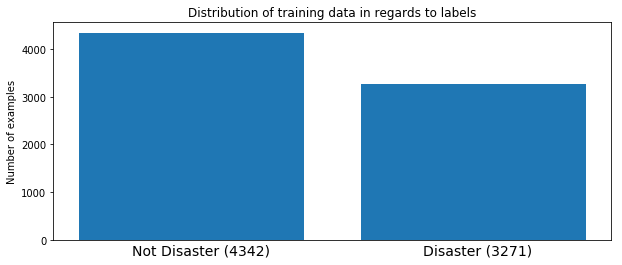

In [11]:
fig,ax=plt.subplots(1,1,figsize=(10,4))
ax.set_xticks([])
ax.set_xlabel("Not Disaster (4342)                                  Disaster (3271)", fontsize=14)
ax.set_ylabel("Number of examples")
ax.set_title("Distribution of training data in regards to labels")
plt.bar(counts_per_target.index,counts_per_target.values)

In [12]:
print('There are {:.2f} % of "Not Disaster" examples'.format(100*4342/7613))
print('There are {:.2f} % of "Disaster" examples'.format(100*3271/7613))

There are 57.03 % of "Not Disaster" examples
There are 42.97 % of "Disaster" examples


The training data is fairly balanced in regards to label: about 50-50

### Duplicate examples

We computed the balance based on ids. However, there may be duplicates. Let us first verify how many unique samples there are in both datasets, based on text. Then we will need to see if some examples in the training set, even though they have different ids, may be labeled differently.

In [13]:
print(np.sum(df_train.groupby(['text']).nunique()))

id          7613
keyword     7465
location    5044
text        7503
target      7521
length      7503
dtype: int64


So there are 7503 unique texts. Some of these texts have more than one id, because the id column sums to 7613, the number of examples. Furthermore, some of these texts have different labels, because the target column sums to 7521, which is more than 7503. Since there are only two possible values for labels, this means there are exactly $7521-7503=18$ examples with two different labels.

Whereas these duplicates do not throw off the "Disaster" vs "Not Disaster" balance as there are only 110, the 18 examples labeled both ways affect training accuracy. We may throw them out. Alternatively, we can choose to simply keep one interpretation. 

This brings us to the more difficult part: cleaning the data.

### Cleaning the data

Before we can start cleaning the text data, we need to clean the keyword, which often contains the string "%20", which we need to replace by a space. After that, we can merge the clean keyword with the text colums.

In [14]:
df_train = pd.read_csv('nlp-getting-started/train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('nlp-getting-started/test.csv', dtype={'id': np.int16})

In [15]:
def clean_keyword(keyword):
    return re.sub(r"%20", " ", keyword)

In [16]:
df_train['clean_keyword'] = df_train['keyword'].astype(str).apply(lambda s : clean_keyword(s))
df_test['clean_keyword'] = df_test['keyword'].astype(str).apply(lambda s : clean_keyword(s))   

In [17]:
df_train['combined_text']= df_train['clean_keyword']+' '+df_train['text']

In [18]:
df_train.sample(5)

,id,keyword,location,text,target,clean_keyword,combined_text
5382,7680,panic,NaN,@panic awesome thanks.,0,panic,panic @panic awesome thanks.
7403,10591,wounded,"Paterson, New Jersey",Officer Wounded Suspect Killed in Exchange of ...,1,wounded,wounded Officer Wounded Suspect Killed in Exch...
6445,9220,suicide%20bombing,USA,Turkish troops killed in Kurdish militant 'sui...,1,suicide bombing,suicide bombing Turkish troops killed in Kurdi...
922,1335,blown%20up,"801 SL,UT",Damn greinke got blown up in that first inning,0,blown up,blown up Damn greinke got blown up in that fir...
990,1439,body%20bagging,#EngleWood CHICAGO,Idgaf who tough or who from Canada and who fro...,0,body bagging,body bagging Idgaf who tough or who from Canad...


In [19]:
df_test['combined_text']= df_test['clean_keyword']+' '+df_test['text']
df_test.sample(5)

,id,keyword,location,text,clean_keyword,combined_text
508,1664,bombing,Philippines,Japan marks 70th anniversary of Hiroshima atom...,bombing,bombing Japan marks 70th anniversary of Hirosh...
1554,5225,fatality,NaN,@Blawnndee FATALITY!!!,fatality,fatality @Blawnndee FATALITY!!!
2332,7796,quarantine,NaN,#callofduty #advancedwarfare COD Advanced Warf...,quarantine,quarantine #callofduty #advancedwarfare COD Ad...
2446,8174,rescuers,"ÌÏT: 7.384559,3.8793718",VIDEO: 'We're picking up bodies from water': R...,rescuers,rescuers VIDEO: 'We're picking up bodies from ...
108,366,annihilation,High Desert,***Latest Updates on the Salt River Wild Horse...,annihilation,annihilation ***Latest Updates on the Salt Riv...


In addition to retaining only the unique training examples with one kind of label, looking at the text column of the original data makes it obvious there are lots of non words, mispelled words, special characters used in tweets. This is a problem when using embeddings as a lot of the one grams may not have a recognized embedding. The proportion of one grams recognized as having an embedding is called embedding coverage. We seek to improve the embedding coverage.

So to clean these data, we will use the "clean" function written by Dieter [4] who manually compiled it. This function gets rid of special characters when attached to words, substitutes contractions with their extended version, corrects typos, translates slang, abreviations, hashtags, acronyms and user names, gets rid of urls, separates punctuation signs from words and makes one word out of several when it is obvious they won't have embeddings.

In [20]:
df_train['clean_text'] = df_train['combined_text'].apply(lambda s : clean(s))
df_test['clean_text'] = df_test['combined_text'].apply(lambda s : clean(s))

Let us create a training dataset without duplicates, deeping only one example for examples having different labels.

In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 8 columns):
id               7613 non-null int16
keyword          7552 non-null object
location         5080 non-null object
text             7613 non-null object
target           7613 non-null int8
clean_keyword    7613 non-null object
combined_text    7613 non-null object
clean_text       7613 non-null object
dtypes: int16(1), int8(1), object(6)
memory usage: 379.2+ KB


In [23]:
df_train=df_train.drop_duplicates(subset='clean_text')
df_train.head()

,id,keyword,location,text,target,clean_keyword,combined_text,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,nan,nan Our Deeds are the Reason of this #earthqua...,nan Our Deeds are the Reason of this # earthq...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,nan,nan Forest fire near La Ronge Sask. Canada,nan Forest fire near La Ronge Sask . Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,nan,nan All residents asked to 'shelter in place' ...,nan All residents asked to ' shelter in place...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,nan,"nan 13,000 people receive #wildfires evacuatio...","nan 13,000 people receive # wildfires evacuat..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,nan,nan Just got sent this photo from Ruby #Alaska...,nan Just got sent this photo from Ruby # Alas...


In [24]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7016 entries, 0 to 7612
Data columns (total 8 columns):
id               7016 non-null int16
keyword          6955 non-null object
location         4700 non-null object
text             7016 non-null object
target           7016 non-null int8
clean_keyword    7016 non-null object
combined_text    7016 non-null object
clean_text       7016 non-null object
dtypes: int16(1), int8(1), object(6)
memory usage: 404.2+ KB


Note that getting rid of duplicates substantially reduced the number of training examples to 7016, from 7613

Now let's drop all the now useless columns: keyword, location, combined_text for both training and test sets

In [25]:
df_train=df_train.drop(labels=['keyword','location','text','clean_keyword','combined_text'],axis=1)
df_train.sample(5)

,id,target,clean_text
4327,6146,0,hijack REVEALED : Everton hijack United bid f...
1809,2599,0,crash Crash helmet silvery floors karnal fat s...
6323,9039,0,stretcher @ DareToTaha nah but thinking of ge...
3667,5221,0,fatality Fatality !
3763,5345,1,fire California been shaking . . . catching ...


In [26]:
df_test=df_test.drop(labels=['keyword','location','text','clean_keyword','combined_text'],axis=1)
df_test.sample(5)

,id,clean_text
2796,9304,survive theyre training all the celebrities 2 ...
602,1964,burning buildings ? High Skies - Burning B...
2552,8521,screaming I am fucking screaming
1362,4484,electrocuted @ hairdryer180 you will get elec...
3212,10664,wounds Palestinian rams car into Israeli soldi...


In [27]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7016 entries, 0 to 7612
Data columns (total 3 columns):
id            7016 non-null int16
target        7016 non-null int8
clean_text    7016 non-null object
dtypes: int16(1), int8(1), object(1)
memory usage: 130.2+ KB


In [28]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
id            3263 non-null int16
clean_text    3263 non-null object
dtypes: int16(1), object(1)
memory usage: 31.9+ KB


### Data preprocessing

With cleaner texts augmented with keywords, it is time to split these cleaner texts into words, then using embeddings, generate sequences of semantics vectors to be used by the network. 

The usual method is to tokenize the text: find a unique index for each word found in the clean text of all the tweets, then transform all the text snipets into sequences of indices. Then build an embedding matrix which will match examples translated into sequences of indices, also called sequences of tokens to semantic vectors also known as embeddings using this embedding matrix.

The problem with this method is that it reinvents the wheel with every epoch, dynamically matching each token to its embedding. Because the goal is to iterate through models fast, we want the models to not be bogged down with reinventing the wheel and, thanks to the fact the data is not very large, rather than dynamically translating tokens into embeddings, we will transform the data into sequences of embeddings which we will use as inputs to the network.

As for the embeddings, we will use the Glove embeddings with 100 dimensions [6]. Granted, 300 would be better, but this computer does not have a large Random Access Memory and once again the goal is to iterate through models rapidly.

First we need to transform the cleaned text into sequences of words and translate these words into embeddings, leaving off the words that do not have an embedding. For this we use a function. This function also returns the lengths of the sequences of embeddings. We need to know how long the longest sequence is, in order to make them fit in a numpy array used by the network, so the same function returns the sequences lengths.

In [29]:
def get_embedding_sequences_and_lengths(all_texts,embedding_dict,df_embeddings_vectors):
    texts = all_texts.apply(lambda string: string.split()).values
    sequences_list =[]
    sequences_lengths=np.zeros([len(all_texts)],np.int32)
    idx=0
    
    for text in texts:
        list_item = []
        for word in text:
            try:
                list_item.append(np.array(df_embeddings_vectors.iloc[embedding_dict[word]])[1:])
            except:
                pass
        sequences_list.append(list_item)
        sequences_lengths[idx]=len(list_item)
        idx+=1
    return sequences_list, sequences_lengths

In [30]:
df_embed=pd.read_csv('tmp/glove.6B.100d.csv',sep=' ')
df_embed.head(10)

,word,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,the,-0.038194,-0.244870,0.728120,-0.399610,0.083172,0.043953,-0.391410,0.334400,-0.575450,...,0.016215,-0.017099,-0.389840,0.874240,-0.725690,-0.510580,-0.520280,-0.145900,0.827800,0.270620
1,",",-0.107670,0.110530,0.598120,-0.543610,0.673960,0.106630,0.038867,0.354810,0.063510,...,0.349510,-0.722600,0.375490,0.444100,-0.990590,0.612140,-0.351110,-0.831550,0.452930,0.082577
2,.,-0.339790,0.209410,0.463480,-0.647920,-0.383770,0.038034,0.171270,0.159780,0.466190,...,-0.063351,-0.674120,-0.068895,0.536040,-0.877730,0.318020,-0.392420,-0.233940,0.472980,-0.028803
3,of,-0.152900,-0.242790,0.898370,0.169960,0.535160,0.487840,-0.588260,-0.179820,-1.358100,...,0.187120,-0.018488,-0.267570,0.727000,-0.593630,-0.348390,-0.560940,-0.591000,1.003900,0.206640
4,to,-0.189700,0.050024,0.190840,-0.049184,-0.089737,0.210060,-0.549520,0.098377,-0.201350,...,-0.131340,0.058617,-0.318690,-0.614190,-0.623930,-0.415480,-0.038175,-0.398040,0.476470,-0.159830
5,and,-0.071953,0.231270,0.023731,-0.506380,0.339230,0.195900,-0.329430,0.183640,-0.180570,...,0.014487,-0.625900,-0.323670,0.418620,-1.080700,0.467420,-0.499310,-0.718950,0.868940,0.195390
6,in,0.085703,-0.222010,0.165690,0.133730,0.382390,0.354010,0.012870,0.224610,-0.438170,...,0.402150,-0.127460,-0.202280,0.873680,-0.545000,0.792050,-0.206950,-0.074273,0.758080,-0.342430
7,a,-0.270860,0.044006,-0.020260,-0.173950,0.644400,0.712130,0.355100,0.471380,-0.296370,...,0.572010,0.088945,-0.425320,-0.018253,-0.079995,-0.285810,-0.010890,-0.492300,0.636870,0.236420
8,"\""",-0.304570,-0.236450,0.175760,-0.728540,-0.283430,-0.256400,0.265870,0.025309,-0.074775,...,-0.658000,-0.167350,0.351580,0.743370,0.260740,0.061104,-0.390790,-0.845570,-0.035432,0.170360
9,'s,0.588540,-0.202500,0.734790,-0.683380,-0.196750,-0.180200,-0.391770,0.341720,-0.605610,...,1.014900,0.776490,0.125980,0.547790,-1.031600,0.064599,-0.375230,-0.944750,0.618020,0.395910


In [31]:
# Now we have to match each word of the tweet texts with its proper embedding
# To do this, we create a dictionary which will give the index of the glove embedding to each word
embed_dict={}
for idx in range(len(df_embed.word)):
    embed_dict[df_embed.word.iloc[idx]]=idx

In [32]:
training_data_lists, training_data_lengths = get_embedding_sequences_and_lengths(df_train.clean_text,embed_dict,df_embed)

In [33]:
test_data_lists, test_data_lengths = get_embedding_sequences_and_lengths(df_test.clean_text,embed_dict,df_embed)

Let's look at the lengths of the longest and the shortest sequences

In [34]:
print(np.max(training_data_lengths))
print(np.min(training_data_lengths))
print(len(training_data_lengths))

73
0
7016


In [35]:
print(test_data_lists[:1][:2])

[[array([0.2822, 0.076347, 0.63594, -0.046165, -0.9581200000000001,
       0.035910000000000004, 0.17794000000000001, 0.33888,
       0.6360399999999999, -0.26398, 0.67681, 0.91525, 0.31785, 0.043176,
       -0.017915, -0.16084, -0.56882, 0.41906000000000004, -1.1378,
       0.6856300000000001, 0.64167, -0.15455, -0.34289000000000003,
       -0.5744600000000001, -0.0013959, -0.13242, -0.16534000000000001,
       -0.17055, 0.27967, -0.16122, -0.0071182, 0.3657, 0.54495, -0.12709,
       -0.80743, -0.36073, -0.27646, 0.25572, 0.40846, -0.6975,
       -0.35978000000000004, 0.10127, 0.14598, -0.10372999999999999,
       -0.64628, -0.022096, 0.71831, -0.20565999999999998,
       -0.15119000000000002, -1.2612, 0.43346999999999997, 0.15759,
       0.1363, 0.8431799999999999, -0.27804, -1.9396,
       -0.45403000000000004, 0.42191999999999996, 1.0506, 0.60069,
       -0.7640899999999999, 1.6647, -0.11225999999999998, -0.57352,
       0.80484, 0.21952, 0.25744, 0.077405, -0.29348, 0.46981000000

In [36]:
print(np.max(test_data_lengths))
print(np.min(test_data_lengths))
print(len(test_data_lengths))

51
0
3263


The shortest training sequence has no intelligible word in it. The longest has 73. The shortest test sequence has zero intelligible word in it and the longest has 51. So the input data numpy array for the training data will be 7016 by 73 by 100 and the one for testing 3263 by 73 by 100.

In [37]:
def convert_lists_to_numpy_array(seq_lists,seq_lengths):
    matrix=np.zeros([len(seq_lists),np.max(seq_lengths),100])
    for example in range(len(seq_lists)):
        for word_embedding in range(seq_lengths[example]):
            matrix[example,word_embedding]=seq_lists[example][word_embedding]
    return matrix

In [38]:
sentences_train_val=convert_lists_to_numpy_array(training_data_lists,training_data_lengths)

In [39]:
sentences_test=convert_lists_to_numpy_array(test_data_lists,test_data_lengths)

Let's now get a numpy array for the labels, so we can get rid of the dataframes

In [40]:
labels_train_val=np.array(df_train.target)
print(labels_train_val.shape)

(7016,)


In [41]:
del df_train
del df_test
del df_embed
del embed_dict
del training_data_lists
del training_data_lengths
del test_data_lists
del test_data_lengths

Finally, we shuffle the data and split it. 

In [42]:
X_train_val,y_train_val=shuffle(sentences_train_val,labels_train_val)

In [43]:
X_train,X_val,y_train,y_val=train_test_split(X_train_val,y_train_val,test_size=0.2)

## Step 3: model iterations

### Initial Model

Let us try a simple model first: an LSTM, followed by an ouput layer with sigmoid activation, because the task is binary classification. We therefore use the binary cross entropy loss. We use Adam as an optimizer as a first choice. 

Because the model tends to overfit quickly, we add a Dropout layer.

In [119]:
max_length=32

In [120]:
model = tf.keras.Sequential([
    tf.keras.layers.Dropout(0.5,input_shape=(max_length,100)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [122]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(lr=0.001),metrics=['accuracy'])
#model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.RMSprop(lr=0.0005),metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_14 (Dropout)         (None, 32, 100)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 42,305
Trainable params: 42,305
Non-trainable params: 0
_________________________________________________________________


In [124]:
num_epochs = 12
history = model.fit(X_train[:,:max_length,:], y_train, epochs=num_epochs, validation_data=(X_val[:,:max_length,:], y_val),
                    shuffle=True)

Train on 5612 samples, validate on 1404 samples
Epoch 1/5
5612/5612 [==============================] - 10s 2ms/step - loss: 0.4736 - acc: 0.7801 - val_loss: 0.4507 - val_acc: 0.8091
Epoch 2/5
5612/5612 [==============================] - 10s 2ms/step - loss: 0.4689 - acc: 0.7782 - val_loss: 0.4507 - val_acc: 0.8056
Epoch 3/5
5612/5612 [==============================] - 10s 2ms/step - loss: 0.4587 - acc: 0.7903 - val_loss: 0.4443 - val_acc: 0.8127
Epoch 4/5
5612/5612 [==============================] - 10s 2ms/step - loss: 0.4623 - acc: 0.7846 - val_loss: 0.4437 - val_acc: 0.7899
Epoch 5/5
5612/5612 [==============================] - 10s 2ms/step - loss: 0.4454 - acc: 0.7990 - val_loss: 0.4444 - val_acc: 0.8020


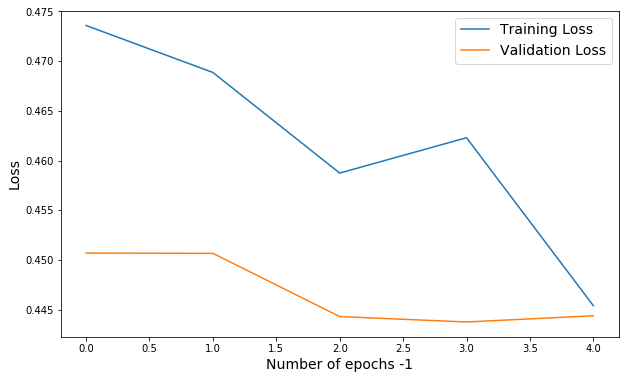

In [127]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.plot(train_loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
ax.set_xlabel("Number of epochs -1", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.legend(loc="upper right", fontsize=14)

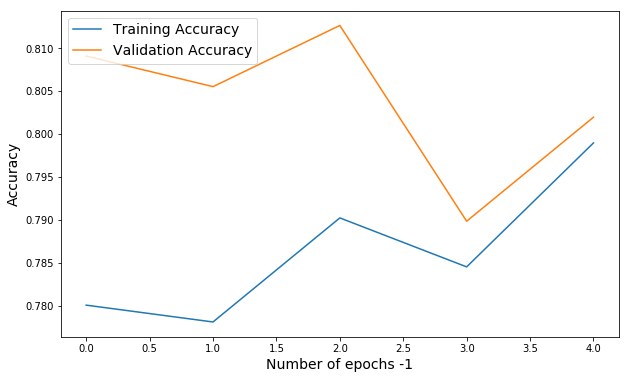

In [128]:
train_acc=history.history['acc']
val_acc=history.history['val_acc']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.plot(train_acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
ax.set_xlabel("Number of epochs -1", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.legend(loc="upper left", fontsize=14)

This initial model yields a modest validation accuracy. Let's try to do a hyperparameter search to find better parameters.

#### Initial model hyperparameter search

There are several hyperparameters that need to be optimized in this simple model. 

First, we crop the sequences. Most of the sequences have lengths way below 73, some are even of zero length. So the longer the sequences used, the more noise introduced by padding the sequences with zero we introduce with short sequences, even though we gain in signal for the longer ones. There is an optimum to be found. We will test lenghts of 16, 32 and 48.

Second, there is the choice of optimizer and initial learning rate: we will try Adam and RMSprop with inital learning rates of 0.001, 0.0005, 0.0001 and 0.00005.

We will use a Dropout probability of 0.25 and 0.5.

This makes a total of 48 possibilities. We will train on 12 epochs. We will look at the training and validation curves to determine the best set of hyperparameters.

In [129]:
num_epochs=12
histories=[]
op_adam=[tf.keras.optimizers.Adam(lr=0.001),tf.keras.optimizers.Adam(lr=0.0005),
        tf.keras.optimizers.Adam(lr=0.0001),tf.keras.optimizers.Adam(lr=0.00005)]
op_rms=[tf.keras.optimizers.RMSprop(lr=0.001),tf.keras.optimizers.RMSprop(lr=0.0005),
        tf.keras.optimizers.RMSprop(lr=0.0001),tf.keras.optimizers.RMSprop(lr=0.00005)]
opt=[op_adam,op_rms]
max_lengths=[16,32,48]
dropout_probas=[0.25,0.5]

for max_length in max_lengths:
    for adam_vs_rms in range(2):
        for l_r in range(4):
            for proba in dropout_probas:
                model = tf.keras.Sequential([
                    tf.keras.layers.Dropout(proba,input_shape=(max_length,100)),
                    tf.keras.layers.LSTM(64),
                    tf.keras.layers.Dense(1, activation='sigmoid')
                ])
                model.compile(optimizer=opt[adam_vs_rms][l_r],loss='binary_crossentropy',metrics=['acc'])
                history = model.fit(X_train[:,:max_length,:], y_train, epochs=num_epochs,
                                    validation_data=(X_val[:,:max_length,:], y_val),shuffle=True)
                histories.append(history)

Train on 5612 samples, validate on 1404 samples
Epoch 1/12
5612/5612 [==============================] - 8s 1ms/step - loss: 0.5602 - acc: 0.7190 - val_loss: 0.5471 - val_acc: 0.7436
Epoch 2/12
5612/5612 [==============================] - 5s 962us/step - loss: 0.5063 - acc: 0.7580 - val_loss: 0.4741 - val_acc: 0.7885
Epoch 3/12
5612/5612 [==============================] - 5s 959us/step - loss: 0.4939 - acc: 0.7664 - val_loss: 0.4688 - val_acc: 0.7927
Epoch 4/12
5612/5612 [==============================] - 5s 963us/step - loss: 0.4874 - acc: 0.7666 - val_loss: 0.4599 - val_acc: 0.7821
Epoch 5/12
5612/5612 [==============================] - 5s 969us/step - loss: 0.4739 - acc: 0.7755 - val_loss: 0.4502 - val_acc: 0.7856
Epoch 6/12
5612/5612 [==============================] - 5s 959us/step - loss: 0.4637 - acc: 0.7864 - val_loss: 0.4495 - val_acc: 0.7863
Epoch 7/12
5612/5612 [==============================] - 5s 959us/step - loss: 0.4519 - acc: 0.7888 - val_loss: 0.4468 - val_acc: 0.8006
Ep

5612/5612 [==============================] - 5s 938us/step - loss: 0.4764 - acc: 0.7748 - val_loss: 0.4489 - val_acc: 0.7999
Epoch 10/12
5612/5612 [==============================] - 5s 947us/step - loss: 0.4723 - acc: 0.7780 - val_loss: 0.4483 - val_acc: 0.7892
Epoch 11/12
5612/5612 [==============================] - 5s 936us/step - loss: 0.4648 - acc: 0.7819 - val_loss: 0.5151 - val_acc: 0.7792
Epoch 12/12
5612/5612 [==============================] - 5s 950us/step - loss: 0.4541 - acc: 0.7904 - val_loss: 0.4369 - val_acc: 0.8098
Train on 5612 samples, validate on 1404 samples
Epoch 1/12
5612/5612 [==============================] - 8s 1ms/step - loss: 0.5755 - acc: 0.7035 - val_loss: 0.4892 - val_acc: 0.7699
Epoch 2/12
5612/5612 [==============================] - 5s 945us/step - loss: 0.5192 - acc: 0.7427 - val_loss: 0.4949 - val_acc: 0.7764
Epoch 3/12
5612/5612 [==============================] - 5s 944us/step - loss: 0.5028 - acc: 0.7600 - val_loss: 0.4638 - val_acc: 0.7892
Epoch 4/12

Epoch 6/12
5612/5612 [==============================] - 10s 2ms/step - loss: 0.4939 - acc: 0.7637 - val_loss: 0.4668 - val_acc: 0.7877
Epoch 7/12
5612/5612 [==============================] - 10s 2ms/step - loss: 0.4925 - acc: 0.7689 - val_loss: 0.4525 - val_acc: 0.7956
Epoch 8/12
5612/5612 [==============================] - 10s 2ms/step - loss: 0.4830 - acc: 0.7714 - val_loss: 0.4513 - val_acc: 0.7942
Epoch 9/12
5612/5612 [==============================] - 10s 2ms/step - loss: 0.4779 - acc: 0.7746 - val_loss: 0.4647 - val_acc: 0.7942
Epoch 10/12
5612/5612 [==============================] - 10s 2ms/step - loss: 0.4756 - acc: 0.7760 - val_loss: 0.4470 - val_acc: 0.7984
Epoch 11/12
5612/5612 [==============================] - 10s 2ms/step - loss: 0.4714 - acc: 0.7823 - val_loss: 0.4719 - val_acc: 0.7906
Epoch 12/12
5612/5612 [==============================] - 10s 2ms/step - loss: 0.4731 - acc: 0.7778 - val_loss: 0.4663 - val_acc: 0.7920
Train on 5612 samples, validate on 1404 samples
Epoc

Epoch 5/12
5612/5612 [==============================] - 10s 2ms/step - loss: 0.4904 - acc: 0.7703 - val_loss: 0.4485 - val_acc: 0.7949
Epoch 6/12
5612/5612 [==============================] - 10s 2ms/step - loss: 0.4726 - acc: 0.7853 - val_loss: 0.4442 - val_acc: 0.8013
Epoch 7/12
5612/5612 [==============================] - 10s 2ms/step - loss: 0.4723 - acc: 0.7808 - val_loss: 0.4691 - val_acc: 0.7949
Epoch 8/12
5612/5612 [==============================] - 10s 2ms/step - loss: 0.4619 - acc: 0.7846 - val_loss: 0.4873 - val_acc: 0.7799
Epoch 9/12
5612/5612 [==============================] - 10s 2ms/step - loss: 0.4535 - acc: 0.7929 - val_loss: 0.4437 - val_acc: 0.7991
Epoch 10/12
5612/5612 [==============================] - 10s 2ms/step - loss: 0.4485 - acc: 0.7963 - val_loss: 0.4343 - val_acc: 0.7970
Epoch 11/12
5612/5612 [==============================] - 10s 2ms/step - loss: 0.4404 - acc: 0.8042 - val_loss: 0.4770 - val_acc: 0.7735
Epoch 12/12
5612/5612 [==============================

Epoch 4/12
5612/5612 [==============================] - 10s 2ms/step - loss: 0.5675 - acc: 0.7133 - val_loss: 0.5243 - val_acc: 0.7514
Epoch 5/12
5612/5612 [==============================] - 10s 2ms/step - loss: 0.5440 - acc: 0.7388 - val_loss: 0.5191 - val_acc: 0.7571
Epoch 6/12
5612/5612 [==============================] - 10s 2ms/step - loss: 0.5406 - acc: 0.7366 - val_loss: 0.4941 - val_acc: 0.7806
Epoch 7/12
5612/5612 [==============================] - 10s 2ms/step - loss: 0.5296 - acc: 0.7457 - val_loss: 0.4899 - val_acc: 0.7870
Epoch 8/12
5612/5612 [==============================] - 10s 2ms/step - loss: 0.5298 - acc: 0.7461 - val_loss: 0.4880 - val_acc: 0.7799
Epoch 9/12
5612/5612 [==============================] - 10s 2ms/step - loss: 0.5218 - acc: 0.7520 - val_loss: 0.4778 - val_acc: 0.7870
Epoch 10/12
5612/5612 [==============================] - 10s 2ms/step - loss: 0.5196 - acc: 0.7455 - val_loss: 0.4760 - val_acc: 0.7877
Epoch 11/12
5612/5612 [==============================]

Epoch 3/12
5612/5612 [==============================] - 14s 3ms/step - loss: 0.6132 - acc: 0.6803 - val_loss: 0.5432 - val_acc: 0.7564
Epoch 4/12
5612/5612 [==============================] - 14s 3ms/step - loss: 0.5392 - acc: 0.7512 - val_loss: 0.5106 - val_acc: 0.7614
Epoch 5/12
5612/5612 [==============================] - 14s 3ms/step - loss: 0.5258 - acc: 0.7527 - val_loss: 0.4956 - val_acc: 0.7849
Epoch 6/12
5612/5612 [==============================] - 14s 3ms/step - loss: 0.5187 - acc: 0.7575 - val_loss: 0.4816 - val_acc: 0.7828
Epoch 7/12
5612/5612 [==============================] - 14s 3ms/step - loss: 0.5048 - acc: 0.7637 - val_loss: 0.4741 - val_acc: 0.7892
Epoch 8/12
5612/5612 [==============================] - 14s 3ms/step - loss: 0.4930 - acc: 0.7716 - val_loss: 0.4656 - val_acc: 0.7842
Epoch 9/12
5612/5612 [==============================] - 14s 3ms/step - loss: 0.4915 - acc: 0.7714 - val_loss: 0.4796 - val_acc: 0.7856
Epoch 10/12
5612/5612 [==============================] 

Epoch 2/12
5612/5612 [==============================] - 15s 3ms/step - loss: 0.5808 - acc: 0.7079 - val_loss: 0.5257 - val_acc: 0.7707
Epoch 3/12
5612/5612 [==============================] - 15s 3ms/step - loss: 0.5461 - acc: 0.7340 - val_loss: 0.5030 - val_acc: 0.7806
Epoch 4/12
5612/5612 [==============================] - 15s 3ms/step - loss: 0.5358 - acc: 0.7420 - val_loss: 0.5171 - val_acc: 0.7642
Epoch 5/12
5612/5612 [==============================] - 15s 3ms/step - loss: 0.5357 - acc: 0.7393 - val_loss: 0.4920 - val_acc: 0.7785
Epoch 6/12
5612/5612 [==============================] - 15s 3ms/step - loss: 0.5309 - acc: 0.7432 - val_loss: 0.4826 - val_acc: 0.7906
Epoch 7/12
5612/5612 [==============================] - 15s 3ms/step - loss: 0.5252 - acc: 0.7471 - val_loss: 0.4798 - val_acc: 0.7849
Epoch 8/12
5612/5612 [==============================] - 15s 3ms/step - loss: 0.5278 - acc: 0.7432 - val_loss: 0.4824 - val_acc: 0.7778
Epoch 9/12
5612/5612 [==============================] -

5612/5612 [==============================] - 21s 4ms/step - loss: 0.6841 - acc: 0.5886 - val_loss: 0.6747 - val_acc: 0.5826
Epoch 2/12
5612/5612 [==============================] - 15s 3ms/step - loss: 0.6416 - acc: 0.6108 - val_loss: 0.5879 - val_acc: 0.7130
Epoch 3/12
5612/5612 [==============================] - 14s 3ms/step - loss: 0.5690 - acc: 0.7226 - val_loss: 0.5417 - val_acc: 0.7621
Epoch 4/12
5612/5612 [==============================] - 14s 3ms/step - loss: 0.5419 - acc: 0.7423 - val_loss: 0.5136 - val_acc: 0.7664
Epoch 5/12
5612/5612 [==============================] - 15s 3ms/step - loss: 0.5269 - acc: 0.7518 - val_loss: 0.4896 - val_acc: 0.7806
Epoch 6/12
5612/5612 [==============================] - 15s 3ms/step - loss: 0.5157 - acc: 0.7623 - val_loss: 0.4781 - val_acc: 0.7863
Epoch 7/12
5612/5612 [==============================] - 15s 3ms/step - loss: 0.5171 - acc: 0.7573 - val_loss: 0.4879 - val_acc: 0.7806
Epoch 8/12
5612/5612 [==============================] - 15s 3ms/st

In [134]:
def plot_losses(hists,max_length_idx,opt_idx,proba_idx):
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(12,10))
    max_lengths=["16","32","48"]
    opt_names=['Adam','RMSprop']
    learning_rates=["0.001","0.0005","0.0001","0.00005"]
    drop_probas=["0.25","0.5"]
    print("Losses for "+max_lengths[max_length_idx]+", "+opt_names[opt_idx]+", Dropout probability: "+drop_probas[proba_idx])    
    for idx in range(4):
        hist_idx=max_length_idx*16+opt_idx*8+idx*2+proba_idx
        axs[idx].plot(hists[hist_idx].history['loss'],label='Training Loss, '+learning_rates[idx])
        axs[idx].plot(hists[hist_idx].history['val_loss'],label='Validation Loss')
        axs[idx].set_xlabel("Number of epochs -1", fontsize=10)
        axs[idx].set_ylabel("Loss", fontsize=10)
        axs[idx].legend(loc="upper right", fontsize=10)

In [135]:
def plot_accuracies(hists,max_length_idx,opt_idx,proba_idx):
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(12,10))
    max_lengths=["16","32","48"]
    opt_names=['Adam','RMSprop']
    learning_rates=["0.001","0.0005","0.0001","0.00005"]
    drop_probas=["0.25","0.5"]
    print("Accuracies for "+max_lengths[max_length_idx]+", "+opt_names[opt_idx]+", Dropout probability: "+drop_probas[proba_idx])
    for idx in range(4):
        hist_idx=max_length_idx*16+opt_idx*8+idx*2+proba_idx
        axs[idx].plot(hists[hist_idx].history['acc'],label='Training Accuracy, '+learning_rates[idx])
        axs[idx].plot(hists[hist_idx].history['val_acc'],label='Validation Accuracy')
        axs[idx].set_xlabel("Number of epochs -1", fontsize=10)
        axs[idx].set_ylabel("Accuracy", fontsize=10)
        axs[idx].legend(loc="upper left", fontsize=10)

Losses for 16, Adam, Dropout probability: 0.25


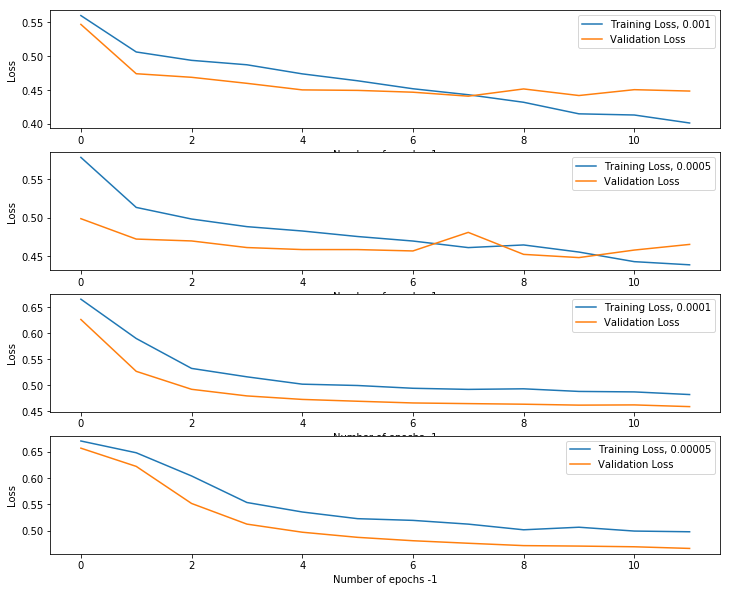

In [136]:
plot_losses(histories,0,0,0)

Accuracies for 16, Adam, Dropout probability: 0.25


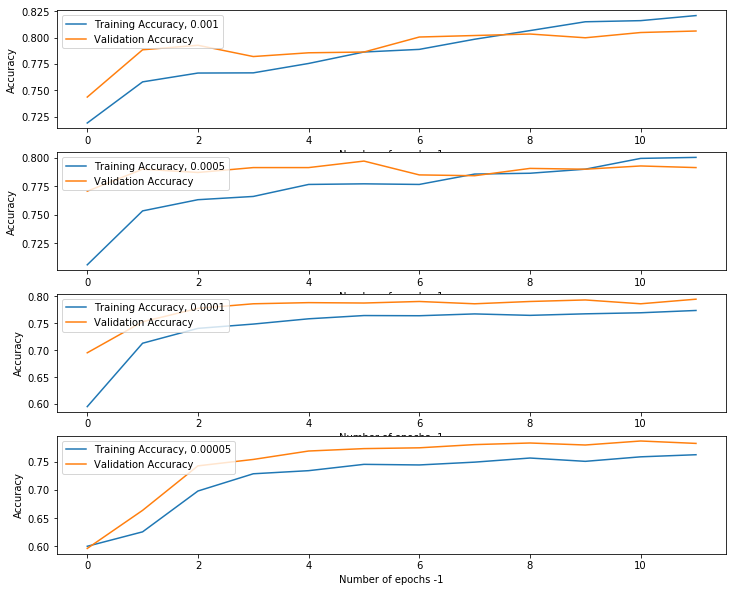

In [137]:
plot_accuracies(histories,0,0,0)

For a maximum sequence length of 16, the Adam optimizer and a Dropout probability of 0.25, the best model seems to be with a learning rate of 0.001, because we can reach a validation accuracy of about 80%. 

Losses for 16, Adam, Dropout probability: 0.5


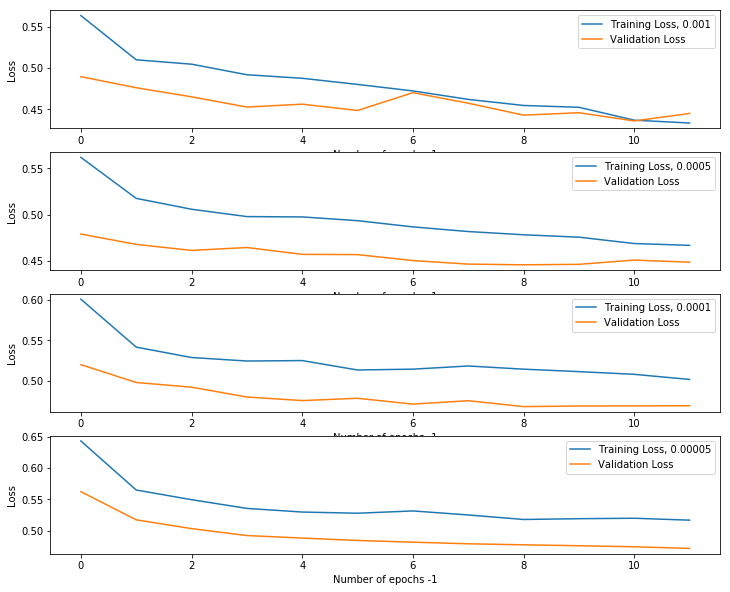

In [138]:
plot_losses(histories,0,0,1)

Accuracies for 16, Adam, Dropout probability: 0.5


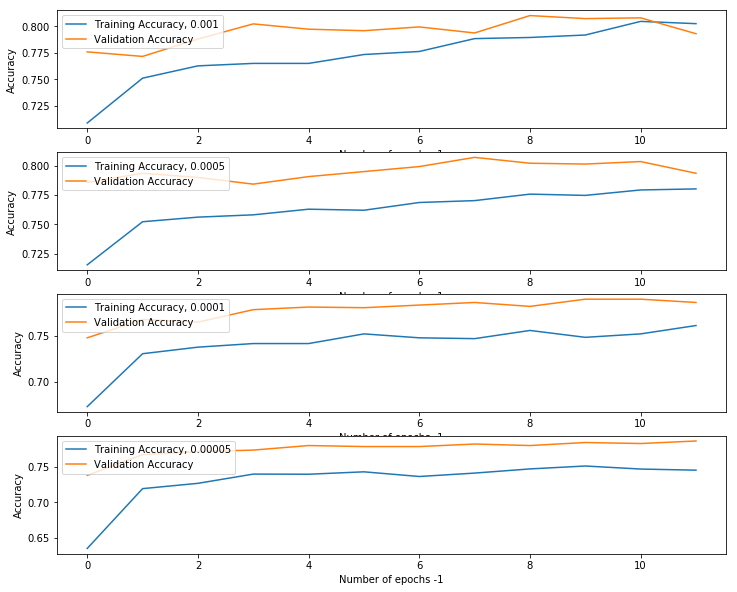

In [139]:
plot_accuracies(histories,0,0,1)

For a maximum sequence length of 16, the Adam optimizer and a Dropout probability of 0.5, the best model seems to be with a learning rate of 0.001, because we can reach a validation accuracy of 80%. The number of epochs needs to be  though, because after that, the model may start to overfit.

The Dropout probability of 0.25 is better, because it overfits less.

Losses for 16, RMSprop, Dropout probability: 0.25


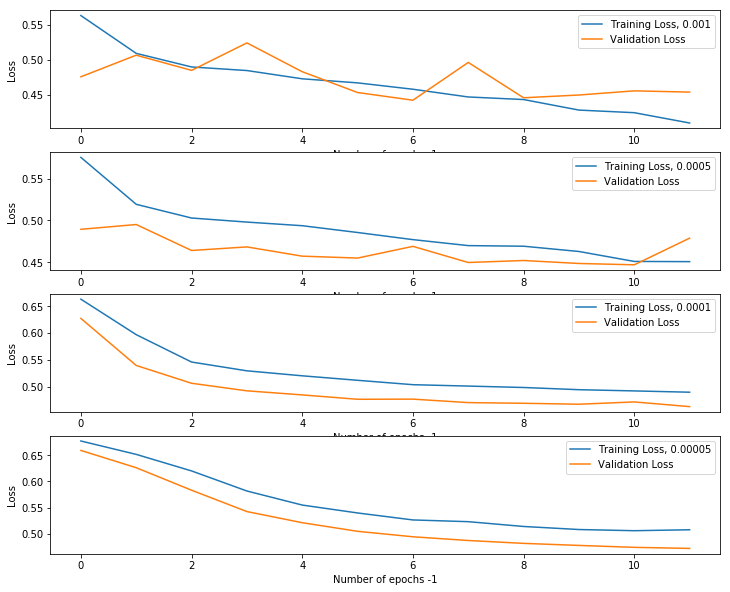

In [140]:
plot_losses(histories,0,1,0)

Accuracies for 16, RMSprop, Dropout probability: 0.25


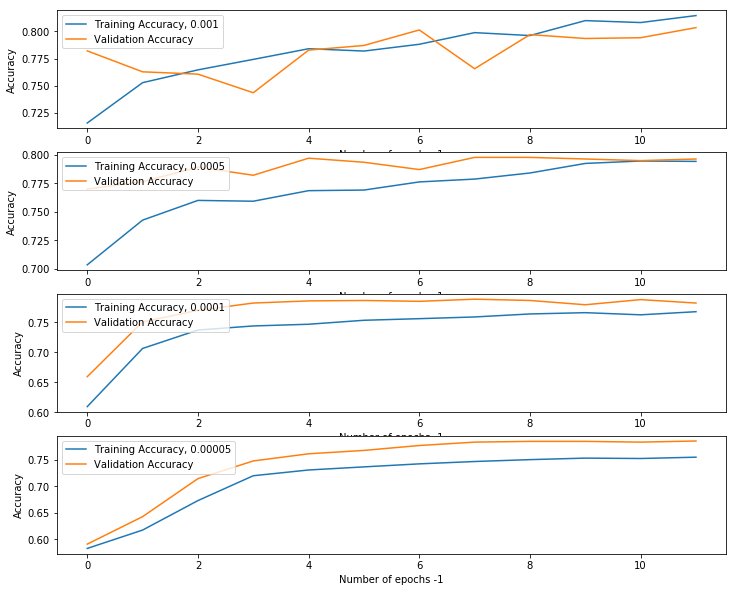

In [141]:
plot_accuracies(histories,0,1,0)

For a maximum sequence length of 16, the RMPprop optimizer and a Dropout probability of 0.25, the best model seems to be with a learning rate of 0.001, because we can reach a validation accuracy of about 80%. 

When comparing to the Adam model, it is unclear which optimizer is better.

Losses for 16, RMSprop, Dropout probability: 0.5


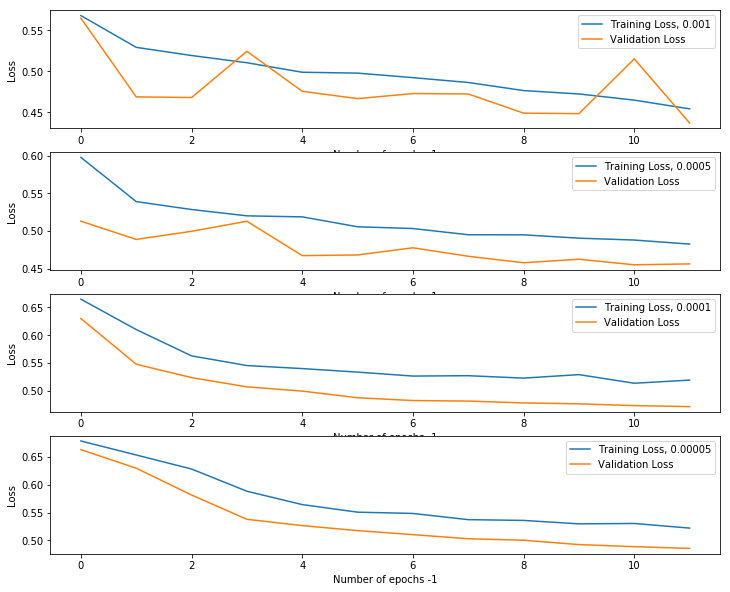

In [142]:
plot_losses(histories,0,1,1)

Accuracies for 16, RMSprop, Dropout probability: 0.5


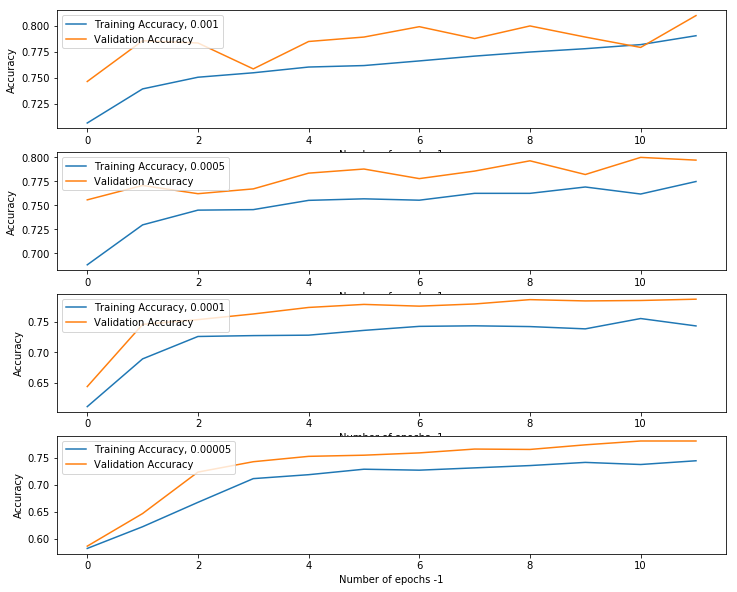

In [143]:
plot_accuracies(histories,0,1,1)

For a maximum sequence length of 16, the RMPprop optimizer and a Dropout probability of 0.25, the best model seems to be with a learning rate of 0.001, because we can reach a validation accuracy of over 80%. 

When comparing to the Adam model, the Adam model seeams a bit better, because the validation accuracy is less jaggy.

Losses for 32, Adam, Dropout probability: 0.25


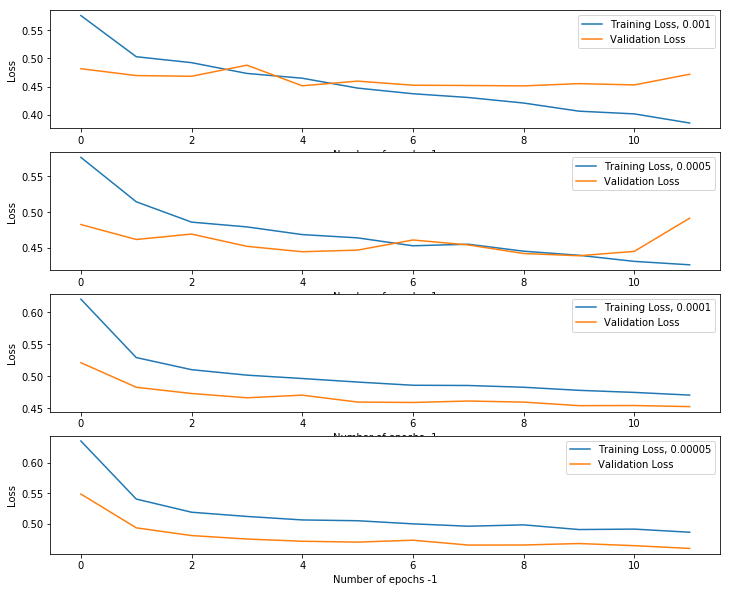

In [144]:
plot_losses(histories,1,0,0)

Accuracies for 32, Adam, Dropout probability: 0.25


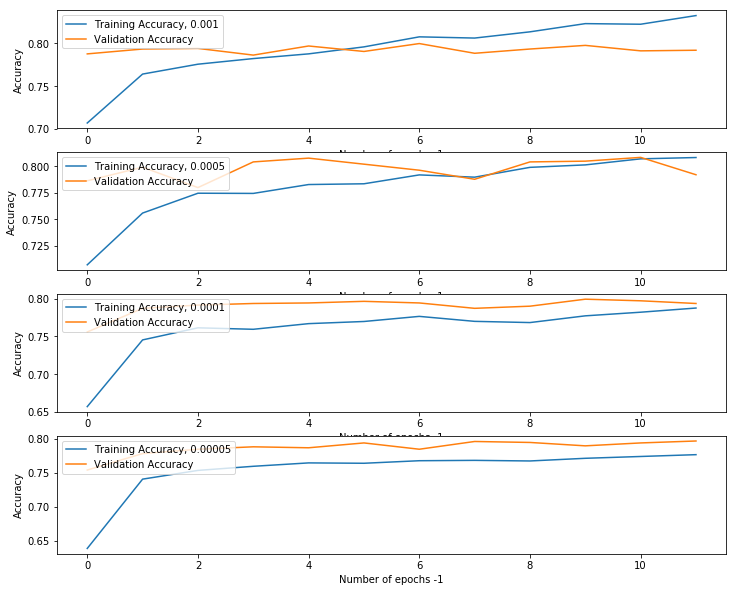

In [145]:
plot_accuracies(histories,1,0,0)

For a maximum sequence length of 32, the Adam optimizer and a Dropout probability of 0.25, the best model seems to be with a learning rate of 0.00005, because the validation curve is the least jaggy. However, none reach a validation accuracy of 80%. The models underfit.

Compared to previous models, the model with a sequence length of 16, the Adam optimizer (RMSprop was about equivalent) and a Dropout probability of 0.25 with is better.

Losses for 32, Adam, Dropout probability: 0.5


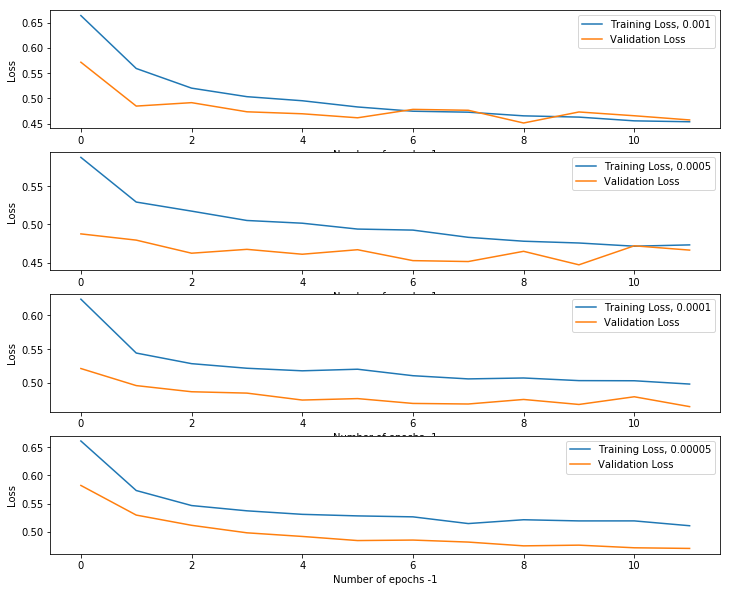

In [146]:
plot_losses(histories,1,0,1)

Accuracies for 32, Adam, Dropout probability: 0.5


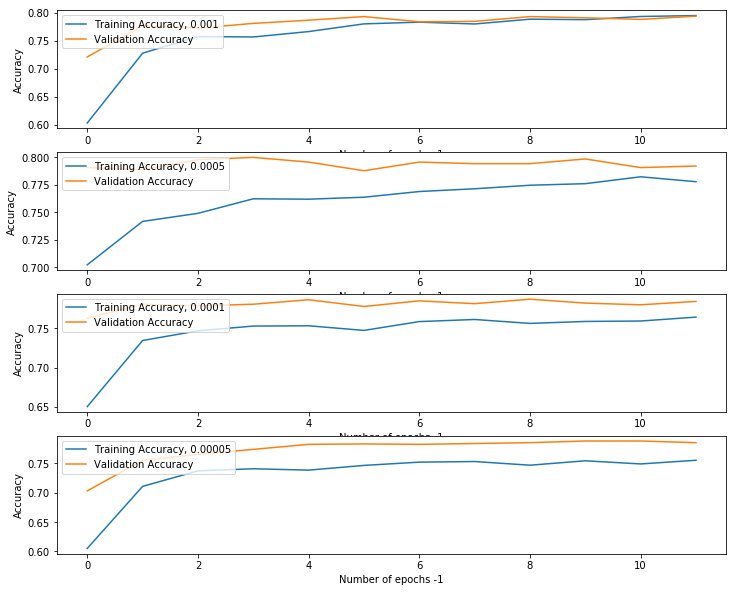

In [148]:
plot_accuracies(histories,1,0,1)

For a maximum sequence length of 32, the Adam optimizer and a Dropout probability of 0.5, the best model seems to be with a learning rate of 0.001, because we can reach a validation accuracy of almost 80%. The number of epochs needs to be  though, because after that, the model overfits.

Compared to previous models, the model with a sequence length of 16, the Adam optimizer (RMSprop was about equivalent) and a Dropout probability of 0.25 with is better.

Losses for 32, RMSprop, Dropout probability: 0.25


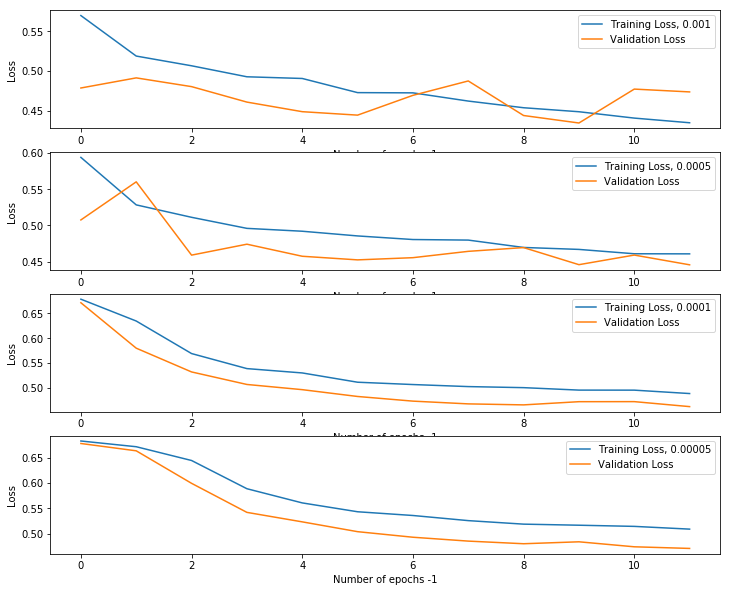

In [149]:
plot_losses(histories,1,1,0)

Accuracies for 32, RMSprop, Dropout probability: 0.25


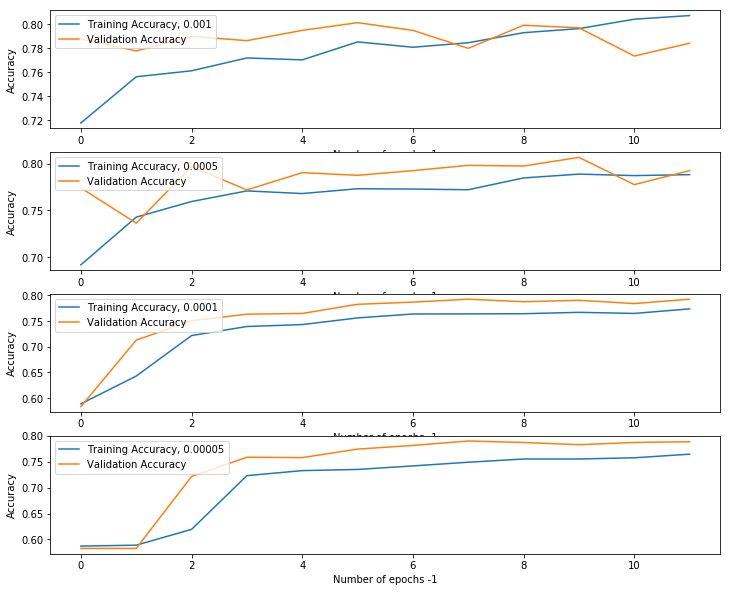

In [150]:
plot_accuracies(histories,1,1,0)

For a maximum sequence length of 32, the RMSprop optimizer and a Dropout probability of 0.25, the best model seems to be with a learning rate of 0.005, because we can reach a validation accuracy of above 80%. However, this validation accuracy goes down after so this result may not be replicable.

Compared to previous models, the model with a sequence length of 16, the Adam optimizer (RMSprop was about equivalent) and a Dropout probability of 0.25 with is better.

Losses for 32, RMSprop, Dropout probability: 0.5


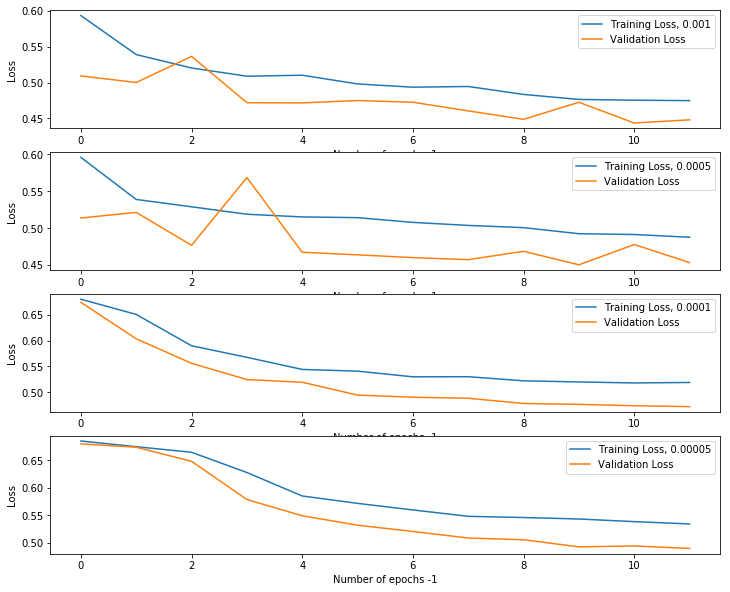

In [151]:
plot_losses(histories,1,1,1)

Accuracies for 32, RMSprop, Dropout probability: 0.5


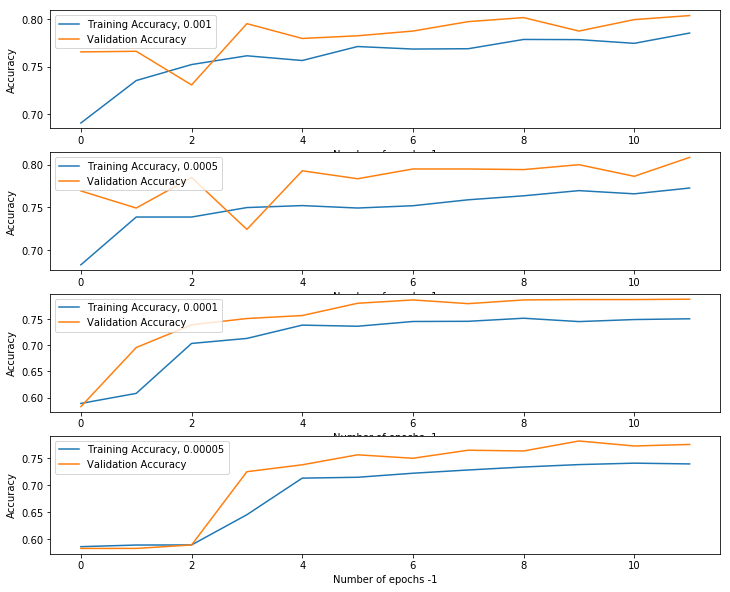

In [152]:
plot_accuracies(histories,1,1,1)

For a maximum sequence length of 32, the RMSprop optimizer and a Dropout probability of 0.5, the best model seems to be with a learning rate of 0.001 or 0.005, because we can reach a validation accuracy of above 80%. 

Compared to previous models, these two models with a maximum sequence length of 32, RMSprop, a learning rate of 0.001 or 0.0005, a are about equivalent to the one with a sequence length of 16, either Adam or RMSprop, a learning rate of 0.001 and a dropout rate of 0.025.

Losses for 48, Adam, Dropout probability: 0.25


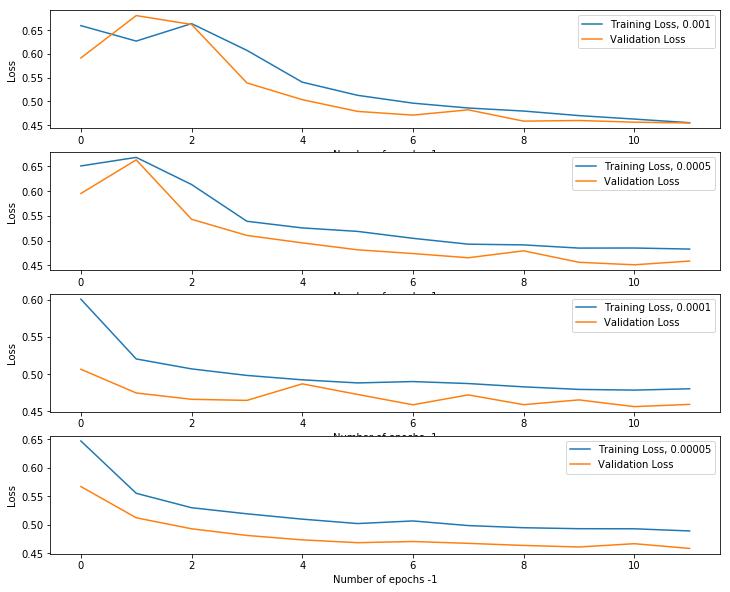

In [153]:
plot_losses(histories,2,0,0)

Accuracies for 48, Adam, Dropout probability: 0.25


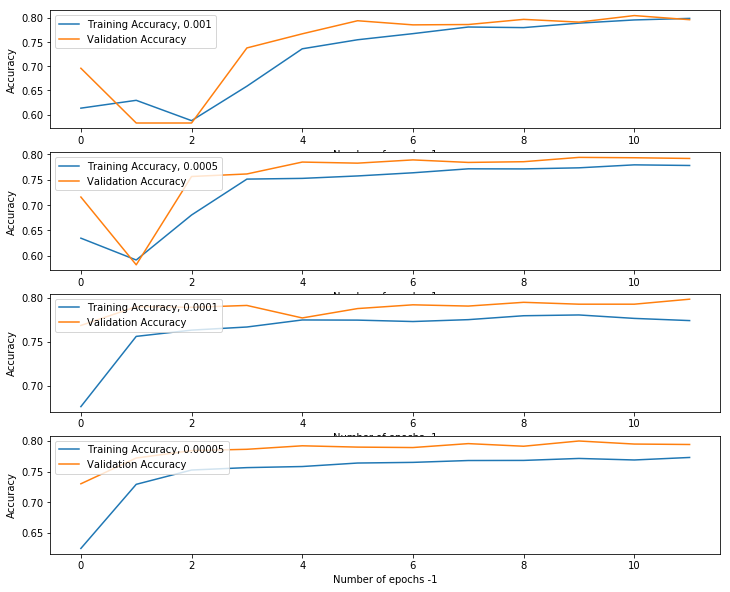

In [154]:
plot_accuracies(histories,2,0,0)

For a maximum sequence length of 48, the Adam optimizer and a Dropout probability of 0.25, the best model seems to be with a learning rate of 0.001, because we can reach a validation accuracy of about 80%. The validation curve is fairly smoote too.

Compared to previous models, the two models with a maximum sequence length of 32, RMSprop, a learning rate of 0.001 or 0.0005, and the ones with a sequence length of 16, either Adam or RMSprop, a learning rate of 0.001 and a dropout rate of 0.025 are slightly better.

This current model has a validation curve that is smoother though.

Losses for 48, Adam, Dropout probability: 0.5


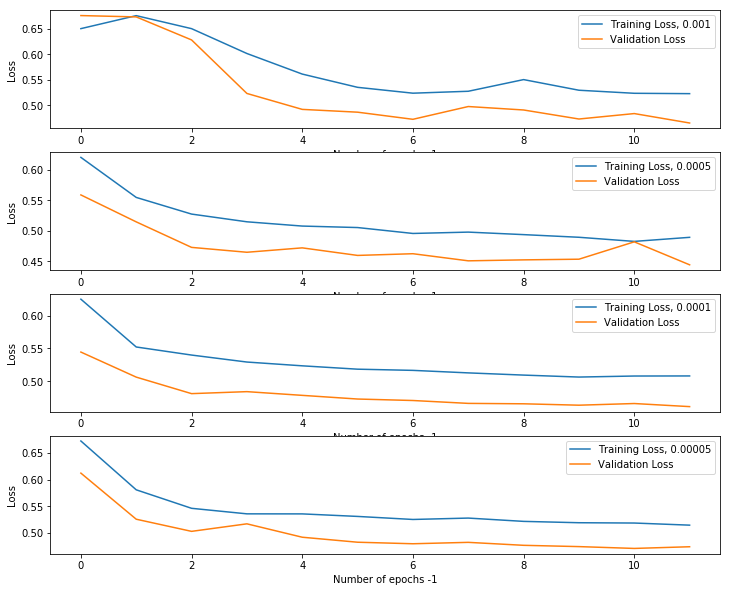

In [155]:
plot_losses(histories,2,0,1)

Accuracies for 48, Adam, Dropout probability: 0.5


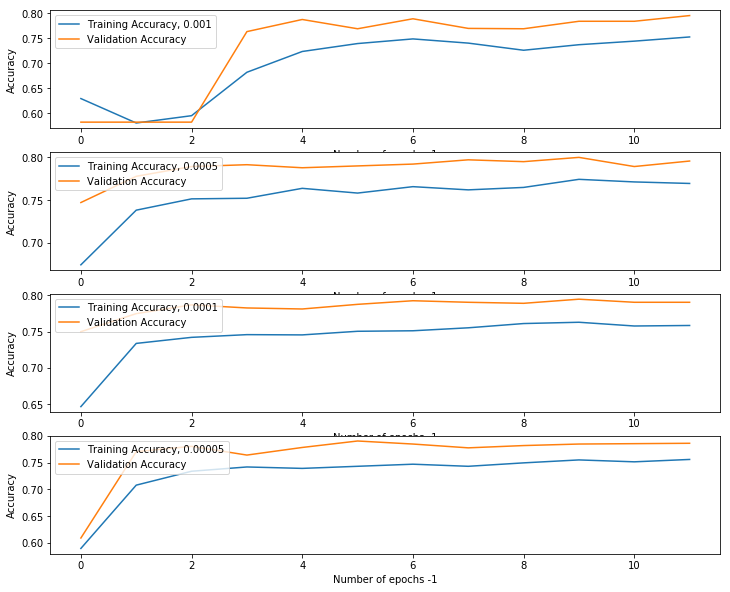

In [156]:
plot_accuracies(histories,2,0,1)

For a maximum sequence length of 48, the Adam optimizer and a Dropout probability of 0.5, the best model seems to be with a learning rate of 0.001, because we can reach a validation accuracy of about 80%. T

Compared to previous models, the two models with a maximum sequence length of 32, RMSprop, a learning rate of 0.001 or 0.0005, and the ones with a sequence length of 16, either Adam or RMSprop, a learning rate of 0.001 and a dropout rate of 0.025 are slightly better.

This model, with a sequence length of 48, the Adam optimizer with a learning rate of 0.001, and a dropout probability of 0.25 with has a validation curve that is smoother though.

Losses for 48, RMSprop, Dropout probability: 0.25


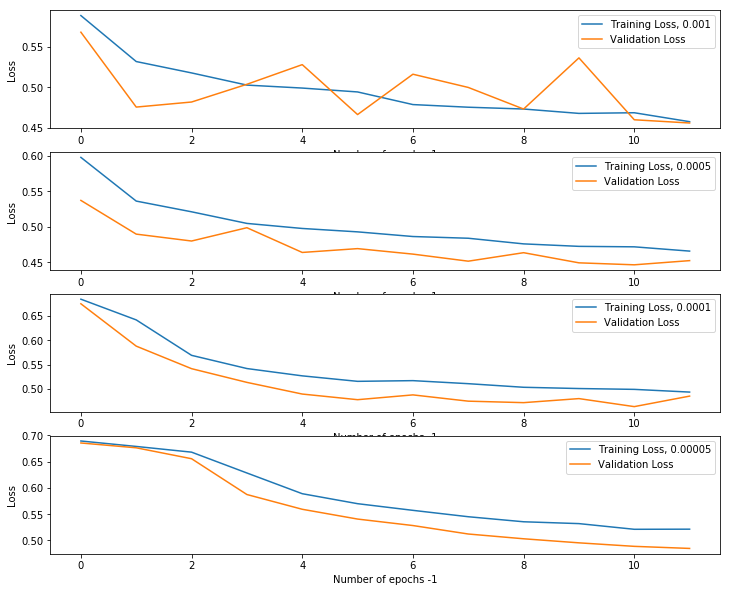

In [157]:
plot_losses(histories,2,1,0)

Accuracies for 48, RMSprop, Dropout probability: 0.25


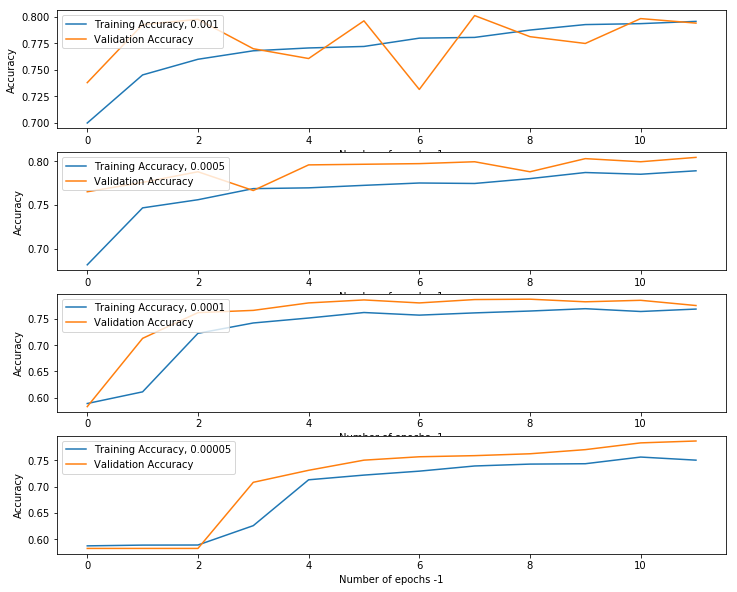

In [158]:
plot_accuracies(histories,2,1,0)

For a maximum sequence length of 48, the RMSprom optimizer and a Dropout probability of 0.25, the best model seems to be with a learning rate of 0.0005, because we can reach a validation accuracy of about 80%. 

Compared to previous models, the two models with a maximum sequence length of 32, RMSprop, a learning rate of 0.001 or 0.0005, and the ones with a sequence length of 16, either Adam or RMSprop, a learning rate of 0.001 and a dropout rate of 0.025 are slightly better.

This model with a sequence length of 48, the RMSprop optimizer with a learning rate of 0.0005, and a dropout probability of 0.25 has a validation curve that is even smoother than the one with a sequence length of 48, the Adam optimizer with a learning rate of 0.001, and a dropout probability of 0.25. In addition, the curve seems to be going up, which suggests a longer number of epochs would further improve the validation accuracy.

Losses for 48, RMSprop, Dropout probability: 0.5


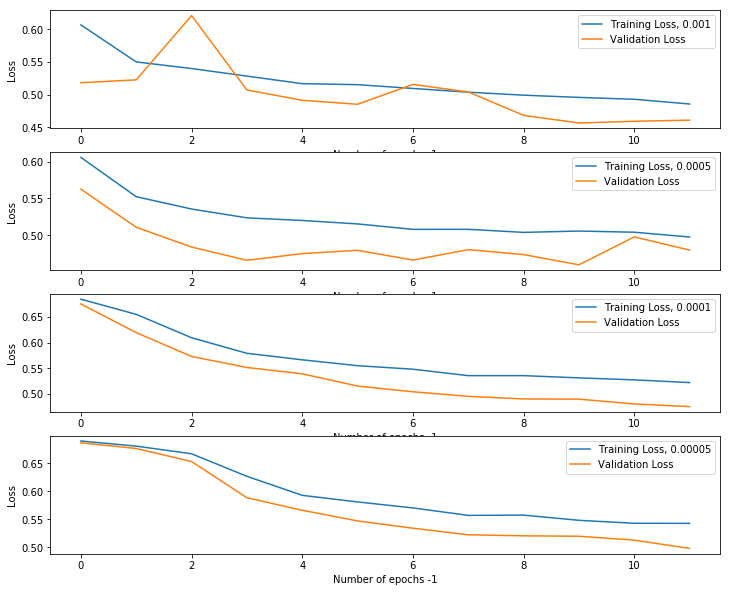

In [159]:
plot_losses(histories,2,1,1)

Accuracies for 48, RMSprop, Dropout probability: 0.5


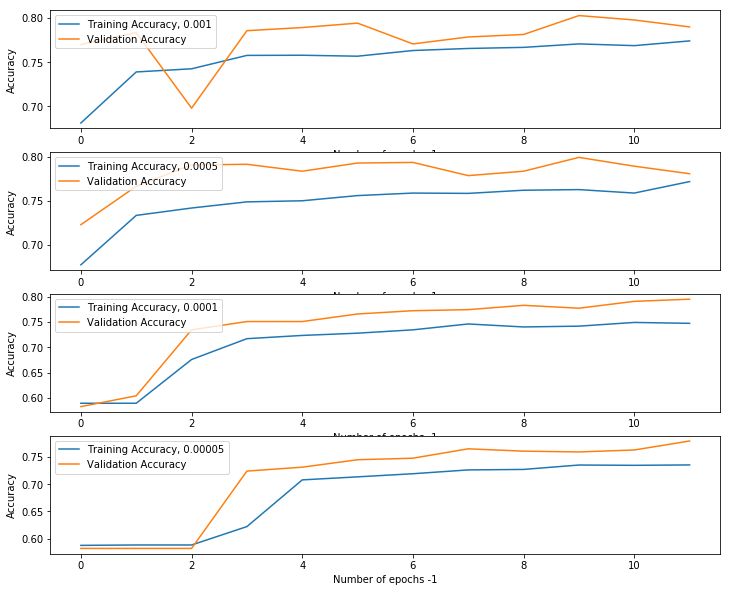

In [160]:
plot_accuracies(histories,2,1,1)

For a maximum sequence length of 48, the RMSprom optimizer and a Dropout probability of 0.5, the best model seems to be with a learning rate of 0.0001, because we can reach a validation accuracy of almost 80%.

Compared to previous models, all the previous ones were better.

Overall, all these models with a learning rate of 0.001 or 0.0005 are remarkably similar as far as the validation accuracy reached is concerned. Using a longer sequence does not really improve this validation accuracy. A maximum length of 16 works better, but a high dropout rate of 0.25 must be used to prevent overfitting. The choice of the optimizer does not matter much.

In this case it is probably best to use the simplest model is probably the best: Adam optimizer, learning rate of 0.001, a maximum sequence length of 16 and a dropout rate of 0.25. Adding early stopping to prevent further overfit would not hurt.

#### Getting the Kaggle F1 score for the test set for the identified best model

Let us retrieve this model first

In [171]:
num_epochs=8
max_length=16
model = tf.keras.Sequential([
    tf.keras.layers.Dropout(0.25,input_shape=(max_length,100)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(lr=0.001),metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_68 (Dropout)         (None, 16, 100)           0         
_________________________________________________________________
lstm_68 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 65        
Total params: 42,305
Trainable params: 42,305
Non-trainable params: 0
_________________________________________________________________


In [172]:
history = model.fit(X_train[:,:max_length,:], y_train, epochs=num_epochs, validation_data=(X_val[:,:max_length,:], y_val),
                    shuffle=True)

Train on 5612 samples, validate on 1404 samples
Epoch 1/8
5612/5612 [==============================] - 13s 2ms/step - loss: 0.5698 - acc: 0.7097 - val_loss: 0.4851 - val_acc: 0.7749
Epoch 2/8
5612/5612 [==============================] - 6s 1ms/step - loss: 0.5022 - acc: 0.7603 - val_loss: 0.4708 - val_acc: 0.7842
Epoch 3/8
5612/5612 [==============================] - 6s 1ms/step - loss: 0.4891 - acc: 0.7701 - val_loss: 0.4714 - val_acc: 0.7842
Epoch 4/8
5612/5612 [==============================] - 6s 1ms/step - loss: 0.4724 - acc: 0.7828 - val_loss: 0.4627 - val_acc: 0.7934
Epoch 5/8
5612/5612 [==============================] - 6s 1ms/step - loss: 0.4649 - acc: 0.7839 - val_loss: 0.4688 - val_acc: 0.7799
Epoch 6/8
5612/5612 [==============================] - 6s 1ms/step - loss: 0.4579 - acc: 0.7931 - val_loss: 0.4733 - val_acc: 0.7949
Epoch 7/8
5612/5612 [==============================] - 6s 1ms/step - loss: 0.4423 - acc: 0.7979 - val_loss: 0.4511 - val_acc: 0.8048
Epoch 8/8
5612/5612 

In [173]:
df_test = pd.read_csv('nlp-getting-started/test.csv', dtype={'id': np.int16})
df_test.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


In [21]:
df_model_submission = pd.read_csv('model_submission.csv')
df_model_submission.head(10)

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
5,12,0
6,21,0
7,22,0
8,27,0
9,29,0


Fortunately, the order of the samples in the test appear the same as in the submission sample, so we can just get the prediction probabilities using the test set we processed.

In [175]:
del df_test
ypp=model.predict(sentences_test[:,:max_length,:])

In [178]:
df_model_submission['target']=np.int32(np.round(ypp))

In [182]:
#df_model_submission.to_csv('my_initial_model_submission.csv',index=False)
#np.save('my_initial_test_predictions.npy',ypp)

#### Getting measurements on the validation data

Let's also collect some measurements, to later display them in the results section. Kaggle will compute an F1 score on the test predictions, but since we do not have the labels for the test set, we cannot do it on the test set. On the other hand, we can do it on the validation set. We will add validation accuracy, validation precision (positive predictive values), validation recall (sensitivity) and finally validation F1, which is the harmonic mean of validation precision and recall.

In [193]:
#measurements=np.zeros([3,5])

In [184]:
ypp=model.predict(X_val[:,:max_length,:])

In [190]:
val_accuracy=history.history['val_acc'][num_epochs-1]
y_pred=np.int32(np.round(ypp))
val_precision=precision_score(y_val,y_pred)
val_recall=recall_score(y_val,y_pred)
val_f1=f1_score(y_val,y_pred)

In [194]:
print(val_accuracy)
print(val_precision)
print(val_recall)
print(val_f1)

0.8027065532159942
0.8035363457760314
0.6979522184300341
0.7470319634703195


In [195]:
measurements[0,:4]=np.array([val_accuracy,val_precision,val_recall,val_f1])

In [23]:
#measurements=np.load('backup_measurements.npy')

In [24]:
#measurements[0,4] = 0.77873
#backup_measurements=measurements
#np.save('backup_measurements.npy',backup_measurements)

### Second iteration

The main drawback of the initial iteration was that we had to limit the length of the sequences, because a lot of them were short, so adding more length meant including spurious data in the input, embedings made of zeros, in the end of input sequences.

So in this iteration, we will attempt to add an attention network to prevent the inputs to the the output layer from being attended to, when spurious outputs are coming out LSTM units when the sequence has passed its natural end.

In [223]:
num_epochs=15
max_length=73
inputs=tf.keras.Input(shape=(max_length, 100))
x1=tf.keras.layers.Dropout(0.25,input_shape=(max_length,100))(inputs)
x2=tf.keras.layers.Conv1D(1,1,activation='sigmoid')(inputs)
x3=tf.keras.layers.LSTM(64,return_sequences=True)(x1)
x4=tf.keras.layers.Multiply()([x3,x2])
x5=tf.keras.layers.Flatten()(x4)
outputs=tf.keras.layers.Dense(1, activation='sigmoid')(x5)

model2=tf.keras.Model(inputs=inputs,outputs=outputs)
model2.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(lr=0.0005),metrics=['accuracy'])
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 73, 100)      0                                            
__________________________________________________________________________________________________
dropout_83 (Dropout)            (None, 73, 100)      0           input_15[0][0]                   
__________________________________________________________________________________________________
lstm_82 (LSTM)                  (None, 73, 64)       42240       dropout_83[0][0]                 
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 73, 1)        101         input_15[0][0]                   
__________________________________________________________________________________________________
multiply_1

In [224]:
history = model2.fit(X_train[:,:max_length,:], y_train, epochs=num_epochs, validation_data=(X_val[:,:max_length,:], y_val),
                     shuffle=True)

Train on 5612 samples, validate on 1404 samples
Epoch 1/15
5612/5612 [==============================] - 32s 6ms/step - loss: 0.5811 - acc: 0.6969 - val_loss: 0.4799 - val_acc: 0.7849
Epoch 2/15
5612/5612 [==============================] - 23s 4ms/step - loss: 0.5085 - acc: 0.7627 - val_loss: 0.4591 - val_acc: 0.7913
Epoch 3/15
5612/5612 [==============================] - 22s 4ms/step - loss: 0.4991 - acc: 0.7689 - val_loss: 0.4535 - val_acc: 0.7949
Epoch 4/15
5612/5612 [==============================] - 22s 4ms/step - loss: 0.4802 - acc: 0.7760 - val_loss: 0.4477 - val_acc: 0.8013
Epoch 5/15
5612/5612 [==============================] - 23s 4ms/step - loss: 0.4752 - acc: 0.7826 - val_loss: 0.4518 - val_acc: 0.7927
Epoch 6/15
5612/5612 [==============================] - 23s 4ms/step - loss: 0.4682 - acc: 0.7810 - val_loss: 0.4489 - val_acc: 0.7906
Epoch 7/15
5612/5612 [==============================] - 23s 4ms/step - loss: 0.4621 - acc: 0.7856 - val_loss: 0.4461 - val_acc: 0.7828
Epoch 8

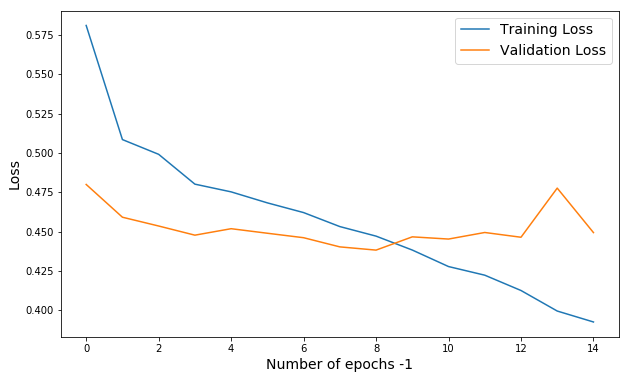

In [225]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.plot(train_loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
ax.set_xlabel("Number of epochs -1", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.legend(loc="upper right", fontsize=14)

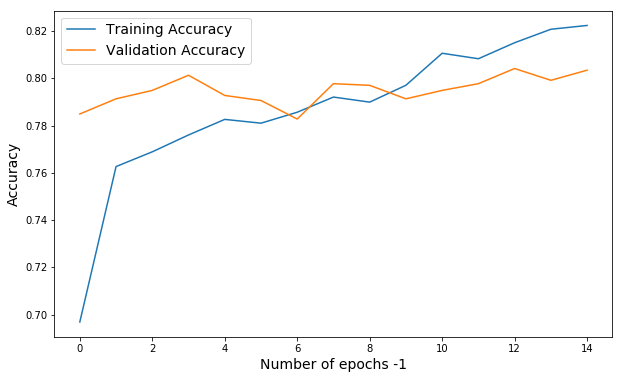

In [226]:
train_acc=history.history['acc']
val_acc=history.history['val_acc']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
plt.plot(train_acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
ax.set_xlabel("Number of epochs -1", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.legend(loc="upper left", fontsize=14)

So adding an attention subnetwork to prevent spurious inputs due to sequence padding from influencing the result helps the network do a lot better with an increased sequence length, but marginally improves validation accuracy. It is perhaps more consistent.

Let's get the Kaggle f1 score

#### Getting the Kaggle F1 score for the test set for this second model

There is a twist. The matrix sentences_test has dimensions: 3263 by 51 by 100. The second dimension does not match the training data second dimension. So we have to pad this matrix with another of dimensions 3263 by 73-51 by 100.

In [230]:
ypp=model2.predict(np.concatenate([sentences_test,np.zeros([3263,max_length-sentences_test.shape[1],100])],axis=1))
df_model_submission = pd.read_csv('model_submission.csv')
df_model_submission['target']=np.int32(np.round(ypp))
#df_model_submission.to_csv('my_second_model_submission.csv',index=False)
#np.save('my_second_test_predictions.npy',ypp)

#### Getting measurements on the validation data

Let's also collect some more measurements, to later display them in the results section. Kaggle will compute an F1 score on the test predictions, but since we do not have the labels for the test set, we cannot do it on the test set. On the other hand, we can do it on the validation set. We will add validation accuracy, validation precision (positive predictive values), validation recall (sensitivity) and finally validation F1, which is the harmonic mean of validation precision and recall.

In [231]:
ypp=model2.predict(X_val[:,:max_length,:])
val_accuracy=history.history['val_acc'][num_epochs-1]
y_pred=np.int32(np.round(ypp))
val_precision=precision_score(y_val,y_pred)
val_recall=recall_score(y_val,y_pred)
val_f1=f1_score(y_val,y_pred)
measurements[1,:4]=np.array([val_accuracy,val_precision,val_recall,val_f1])
print(val_accuracy)
print(val_precision)
print(val_recall)
print(val_f1)

0.8034188035886172
0.7758007117437722
0.7440273037542662
0.759581881533101


In [29]:
#measurements[1,4] = 0.77290
#backup_measurements=measurements
#np.save('backup_measurements.npy',backup_measurements)

This second iteration did not really produce better results. It only produced more consistent results with longer sequences.

## Step 4: Results

A hyperparameter search of the initial model showed that smaller learning rates: 0.0005, 0.0001 or 0.00005 did not produce better validation accuracies than a learning rate of 0.001: they were actually lower, but the validation curves were less jagged. The choice of the optimizer did not really matter: both Adam and RMPprop worked equally well. When using a higher learning rate, a lower probability of dropout was more effective in avoiding overfitting.

But the most crucial hyperparameter was the maximum length used to crop the sequences, which in effect amounted to throwing away the ends of texts. This was because tweet texts were of uneven lengths. There were texts with no intelligible words and texts with up to 73. This resulted in the need to pad sequences embeddings with vectors of zeros in the end, which carry an unknown meaning, introducing spurious information to the network. So what we did was to use an attention subnetwork that could shut down the outputs of the LSTM layer for the ends of the texts. This greatly improved the maxium length admissible, but only marginally improved the accuracy. It did improve the f1 ratio, mainly by improving recall (sensitivity). This is obvious looking at the following table:

In [28]:
print("Summary of Architectures Tried")
column_labels=['Validation Accuracy','Val. Precision','Val. Recall','Val. F1 score','Kaggle test F1 score']
index_labels=['Simple LSTM with Dropout','LSTM with Dropout with Attention sub-network']
df_results=pd.DataFrame(measurements[:2,:],index=index_labels,columns=column_labels)
df_results.head()

Summary of Architectures Tried


,Validation Accuracy,Val. Precision,Val. Recall,Val. F1 score,Kaggle test F1 score
Simple LSTM with Dropout,0.802707,0.803536,0.697952,0.747032,0.77873
LSTM with Dropout with Attention sub-network,0.803419,0.775801,0.744027,0.759582,0.77290


## Step 5: Conclusion

With this notebook, we spend a lot of effort preprocessing the data. This is because tweet data is very "dirty", with lots of acronyms, special characters, mispelled words etc.. which require a lot of cleaning. Where available the keyword attached to the tweet contained a lot of information, so we appended it to the text. Finally, we used Glove embeddings, but rather than making a matrix of non trainable weights part of the network, we translated once and for all the training and test data into embedding vectors after segmenting them into words, in order to iterate through models faster.

We focused on an LSTM model and augmented it with attention. The results were not as good as using pretrained BERT, which is a massive Transformer model with 12 hidden layers, 12 attention heads and hidden layer sizes of 768, but obained validation accuracy values only 5% worse. We did not have the computational resources to implement such a large model, even only doing fine tuning. It was also the solution precribed by Kaggle, so we needed to do something else.

Overall, these modest but honorable results with this Kaggle challenge show there are still lots of lines of inquiry possible when designing sequential models. Transformers currently have the upper hand, necessitating gigantic resources to train. But for how long?

#### Bibliography

[1] Laurence Moroney (2019). Natural Language Processing in Tensorflow. Deeplearning.ai.
https://www.coursera.org/learn/natural-language-processing-tensorflow

[2] Alexia Audevart (2023). KerasNLP starter notebook Disaster Tweets. Kaggle https://www.kaggle.com/alexia/kerasnlp-starter-notebook-diaster-tweets

[3] Gunes Evitan(2019). NLP with Disaster Tweets -EDA, Cleaning and BERT. Kaggle https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

[4] Dieter (2018). How to: Preprocessing when using embeddings. Kaggle. https://www.kaggle.com/code/christofhenkel/how-to-proprocessing-when-using-embeddings

[5] Addison Howard, devrishi, Phil Culliton, Yufeng Guo (2019). Natural Language Processing with Disaster Tweets. Kaggle. https://kaggle.com/competitions/nlp-getting-started

[6] GloVe: Global Vectors for Word Representation https://nlp.stanford.edu/projects/glove/